In [1]:
# libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import pickle
import os

## Data: CIFAR-10 batch 1-5
Source: https://www.cs.toronto.edu/~kriz/cifar.html  
Data in dict:
* "data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image."
* "labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data."

In [2]:
X_train = None
y_train = None
for i in range(5):
    CIFARdict = pickle.load(open('cifar-10-batches-py/data_batch_{}'.format(i+1), 'rb'), encoding='bytes')
    if X_train is None:
        X_train = CIFARdict[b'data']
        y_train = np.array(CIFARdict[b'labels'])
    else:
        X_train = np.concatenate((X_train, CIFARdict[b'data']))
        y_train = np.concatenate((y_train, np.array(CIFARdict[b'labels'])))

print("X_train: {} with shape {}, dtype {}, and values in range {}".format(type(X_train), X_train.shape, X_train.dtype,
                                                          (np.amin(X_train), np.amax(X_train))))
print("y_train: {} with shape {}, dtype {}, and values in range {}".format(type(y_train), y_train.shape, y_train.dtype,
                                                          (np.amin(y_train), np.amax(y_train))))

X_train: <class 'numpy.ndarray'> with shape (50000, 3072), dtype uint8, and values in range (0, 255)
y_train: <class 'numpy.ndarray'> with shape (50000,), dtype int64, and values in range (0, 9)


In [3]:
# function for plotting images
def plotImgs(X, n_examples, n_rows, figsize=(7,7), cmap=None):
    assert n_examples % n_rows == 0
    n_cols = n_examples/n_rows
    plt.figure(1, figsize=figsize)
    for i in range(n_examples):
        img = X[i]
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img, cmap=plt.get_cmap(cmap))
    plt.show()

In [4]:
# https://stackoverflow.com/questions/35995999/why-cifar-10-images-are-not-displayed-properly-using-matplotlib/40144107#40144107
X_train_rgb =  np.transpose(np.reshape(X_train, (X_train.shape[0], 3, 32, 32)), axes=[0,2,3,1])

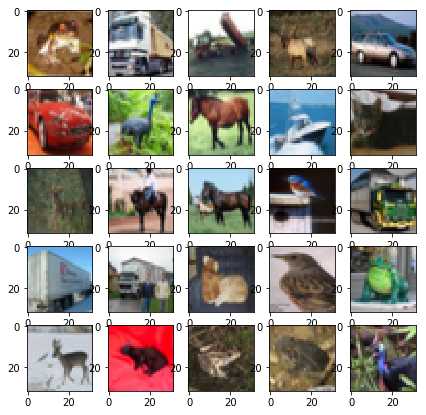

In [5]:
plotImgs(X_train_rgb, 25, 5)

In [6]:
# look at available labels
CIFARdict = pickle.load(open('cifar-10-batches-py/batches.meta', 'rb'), encoding='bytes')
CIFARdict[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [18]:
# get all bird images
# to make an autoencoder that approximates cat images
dex = np.where(y_train == 4)[0]
X_train_rgb_cat = X_train_rgb[dex]

X_train_rgb_cat.shape

(5000, 32, 32, 3)

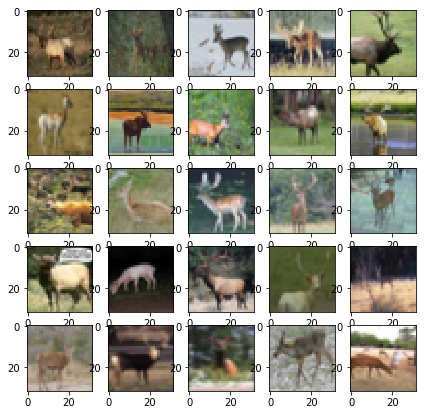

In [19]:
plotImgs(X_train_rgb_cat, 25, 5)

## Preprocessing
References:
* http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing
* https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

In [56]:
def preprocess(X_rgb):
    # grayscale
    ret = np.dot(X_rgb, [0.299, 0.587, 0.114])
    #rescale
#     ret = ret/255
    # no PCA since it feels redundant for an autoencoder
    return ret

In [57]:
X_train_final = np.reshape(preprocess(X_train_rgb_cat), (X_train_rgb_cat.shape[0], -1))
X_train_final.shape

(5000, 1024)

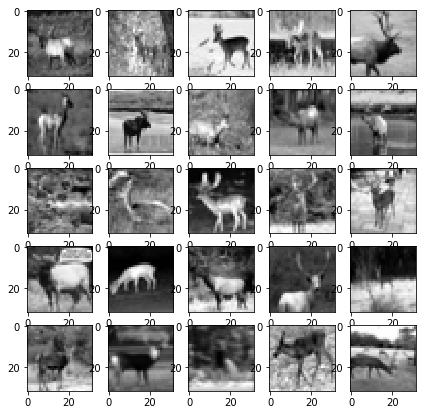

In [58]:
plotImgs(np.reshape(X_train_final, (X_train_final.shape[0], 32, 32)), 25, 5, cmap='gray')

## Autoencoder
References/Tutorials:
* https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/autoencoder.ipynb
* https://github.com/leriomaggio/deep-learning-keras-tensorflow/blob/master/6.%20AutoEncoders%20and%20Embeddings/6.1.%20AutoEncoders%20and%20Embeddings.ipynb
* https://github.com/BinRoot/TensorFlow-Book/blob/master/ch07_autoencoder/Concept02_autoencoder_with_imgs.ipynb

## Build graph

In [60]:
# hyperparameters
lr = 0.001
epochs = 200
batch_size = 128
n_batch = int(X_train_final.shape[0]/batch_size)  # floor
dtype = tf.float32
n_in = X_train_final.shape[1]
n_hidden = int(np.rint(n_in/2))
activate = tf.nn.sigmoid
optimizer = tf.train.RMSPropOptimizer
# rmsprop works better for the larger range of [0,255]
# adam works better for inputs in the range [0,1]

# variables to be trained
with tf.name_scope("weights"):
    weights = {
        'enc': tf.Variable(tf.random_normal([n_in, n_hidden]), dtype=dtype),
        'dec': tf.Variable(tf.random_normal([n_hidden, n_in]), dtype=dtype)
    }
with tf.name_scope("biases"):
    biases = {
        'enc': tf.Variable(tf.random_normal([n_hidden]), dtype=dtype),
        'dec': tf.Variable(tf.random_normal([n_in]), dtype=dtype)
    }

X = tf.placeholder(dtype, [None, n_in], "input")

with tf.name_scope("model"):
    # TODO: 
    # try convolutional autoencoder
    # try http://people.ee.duke.edu/~lcarin/Yunchen_nips_2016.pdf
    # try http://nghiaho.com/?p=1765
    
    encoder = activate(tf.add(tf.matmul(X, weights['enc']), biases['enc']))
    decoder = tf.add(tf.matmul(encoder, weights['dec']), biases['dec'])
    # linear activation if input range is [0,255]
    # sigmoid activation if input range is [0,1]
    # linear with rmsprop produces better results than sigmoid with adam

with tf.name_scope("optimization"):
    cost = tf.reduce_mean(tf.square(tf.subtract(X, decoder)))
    optimization = optimizer(lr).minimize(cost)
    
# TODO: add tf board

## Run graph

In [24]:
# get data in random batches
def getRandBatch(X, batch_size):
    np.random.shuffle(X)
    start = np.random.randint(0, X.shape[0] - batch_size)
    return X[start:start+batch_size, :], start

In [61]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

# train model
for e in tqdm(range(epochs)):
    history_cost = []
    
    X_temp = np.copy(X_train_final)
    for i in range(n_batch):
        batch, start = getRandBatch(X_temp, batch_size)
        X_temp = np.delete(X_temp, np.s_[start:start+batch_size], axis=0)
        _, c = sess.run([optimization, cost], {X: batch})
    if e % 10 == 0:
        print("epoch {}\tcost {}".format(e, c))

  0%|          | 1/200 [00:01<05:51,  1.77s/it]

epoch 0	cost 16724.134765625


  6%|▌         | 11/200 [00:18<05:19,  1.69s/it]

epoch 10	cost 2471.638916015625


 10%|█         | 21/200 [00:40<05:49,  1.95s/it]

epoch 20	cost 2133.12060546875


 16%|█▌        | 31/200 [01:02<05:52,  2.08s/it]

epoch 30	cost 2108.92626953125


 20%|██        | 41/200 [01:20<05:11,  1.96s/it]

epoch 40	cost 1791.5223388671875


 26%|██▌       | 51/200 [01:39<04:38,  1.87s/it]

epoch 50	cost 1734.119873046875


 30%|███       | 61/200 [01:59<04:44,  2.04s/it]

epoch 60	cost 1844.2354736328125


 36%|███▌      | 71/200 [02:19<04:35,  2.13s/it]

epoch 70	cost 1632.162109375


 40%|████      | 81/200 [02:37<03:27,  1.75s/it]

epoch 80	cost 1507.209716796875


 46%|████▌     | 91/200 [02:58<04:09,  2.29s/it]

epoch 90	cost 1520.6683349609375


 50%|█████     | 101/200 [03:19<03:14,  1.96s/it]

epoch 100	cost 1413.9210205078125


 56%|█████▌    | 111/200 [03:40<03:12,  2.16s/it]

epoch 110	cost 1570.6480712890625


 60%|██████    | 121/200 [04:02<02:53,  2.20s/it]

epoch 120	cost 1597.087890625


 66%|██████▌   | 131/200 [04:20<02:05,  1.81s/it]

epoch 130	cost 1459.145751953125


 70%|███████   | 141/200 [04:38<01:41,  1.71s/it]

epoch 140	cost 1446.2862548828125


 76%|███████▌  | 151/200 [04:56<01:35,  1.95s/it]

epoch 150	cost 1311.064453125


 80%|████████  | 161/200 [05:15<01:10,  1.81s/it]

epoch 160	cost 1310.8033447265625


 86%|████████▌ | 171/200 [05:34<00:57,  1.98s/it]

epoch 170	cost 1570.5537109375


 90%|█████████ | 181/200 [05:56<00:43,  2.31s/it]

epoch 180	cost 1311.2359619140625


 96%|█████████▌| 191/200 [06:15<00:17,  1.95s/it]

epoch 190	cost 1252.62158203125


100%|██████████| 200/200 [06:32<00:00,  1.99s/it]


## Plot results

In [62]:
# test model on its input
pred_train = sess.run(decoder, feed_dict={X: X_train_final})

In [63]:
pred_train

array([[  57.48231888,   58.10659409,   57.21570969, ...,  104.22336578,
         107.0302124 ,  101.93379211],
       [  79.39089203,   75.43505859,   74.6953125 , ...,   89.58584595,
          84.74655914,   82.80526733],
       [ 126.13493347,  130.68141174,  121.61589813, ...,  134.88616943,
         139.53842163,  134.92666626],
       ..., 
       [ 153.20834351,  144.16134644,  155.9924469 , ...,  131.45153809,
         131.41165161,  125.75897217],
       [  52.44486237,   54.16254044,   54.69691086, ...,  138.56358337,
         134.89576721,  138.24957275],
       [ 168.81771851,  171.51579285,  164.90336609, ...,  113.12901306,
         118.29336548,  111.99604034]], dtype=float32)

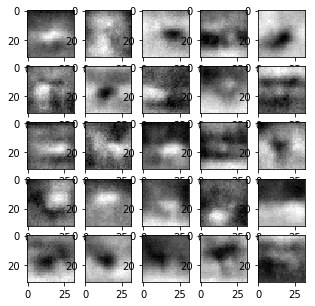

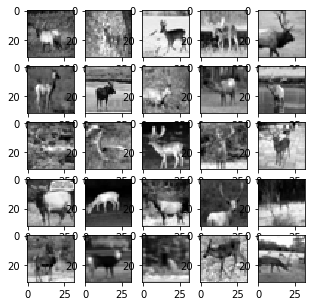

In [64]:
# compare
plotImgs(np.reshape(pred_train, (pred_train.shape[0],32,32)), 25, 5, figsize=(5,5), cmap='gray')
plotImgs(np.reshape(X_train_final, (X_train_final.shape[0], 32, 32)), 25, 5, figsize=(5,5), cmap='gray')